In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve1d
import scipy
import matplotlib.patches as patches


from cca.data_util import moving_center, load_sabes_data, calc_autocorr_fns
from cca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from cca import ComplexityComponentsAnalysis
from cca.cca import DynamicalComponentsAnalysisFFT

In [2]:
#NEURAL_DIR = "/home/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
NEURAL_DIR = "/Users/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
SESSION = "indy_20160627_01.mat" 
NEURAL_FILENAME = NEURAL_DIR + SESSION
BIN_WIDTH_S = .100
MIN_SPIKE_COUNT = 5000
MOVING_WINDOW = 600 #1 min

def load_neural_data():
    results = load_sabes_data(NEURAL_FILENAME, bin_width_s=BIN_WIDTH_S)
    spikes = results["M1"]
    spikes = spikes[:, spikes.sum(axis=0) > MIN_SPIKE_COUNT]
    sqrt_spikes = np.sqrt(spikes)
    sqrt_spikes_ctd = moving_center(sqrt_spikes, n=MOVING_WINDOW)
    cursor = results["cursor"]
    return sqrt_spikes_ctd, cursor

In [72]:
def dca_deflation(cross_cov_mats, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    P = np.eye(N) #orthogonal projection matrix onto residual subspace
    V = None  #orthonormal basis of DCA projections
    opt = ComplexityComponentsAnalysis(init="random")
    for i in range(n_proj):
        print(i)
        cross_cov_mats_proj = np.array([P.dot(C).dot(P.T) for C in cross_cov_mats])
        if i > 0:
            #add isotropic white noise to subtracted-out subspace
            cross_cov_mats_proj[0] += 1e2 * np.dot(V, V.T)
        opt.cross_covs = cross_cov_mats_proj
        opt.fit_projection(d=1, n_init=n_init)
        u = opt.coef_
        if i == 0:
            V = u
        else:
            u_proj = np.dot(P, u)
            u_proj /= np.sqrt(np.sum(u_proj**2))
            V = np.concatenate((V, u_proj), axis=1)
        P = np.eye(N) - np.dot(V, V.T)
    return V

def dca_deflation_smart(cross_cov_mats, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    F = np.eye(N)
    cov_proj = np.copy(cross_cov_mats)
    basis = np.zeros((N, n_proj))
    opt = ComplexityComponentsAnalysis()
    for i in range(n_proj):
        print(i)
        #run DCA
        opt.cross_covs = cov_proj
        opt.fit_projection(d=1, n_init=n_init)
        v = opt.coef_.flatten()
        #get full-dim v
        v_full = np.dot(F, v)
        basis[:, i] = v_full
        #update U, F, cov_proj
        U = scipy.linalg.orth(np.eye(N - i) - np.outer(v, v))
        F = np.dot(F, U)
        cov_proj = np.array([U.T.dot(C).dot(U) for C in cov_proj])
    return basis


def dca_fft_deflation(X, T, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    F = np.eye(N)
    X_proj = np.copy(X)
    basis = np.zeros((N, n_proj))
    opt = DynamicalComponentsAnalysisFFT(T=T)
    for i in range(n_proj):
        print(i)
        #run DCA
        opt.fit(X_proj, d=1, n_init=n_init)
        v = opt.coef_.flatten()
        #get full-dim v
        v_full = np.dot(F, v)
        basis[:, i] = v_full
        #update U, F, cov_proj
        U = scipy.linalg.orth(np.eye(N - i) - np.outer(v, v))
        F = np.dot(F, U)
        X_proj = np.dot(X_proj, U)
    return basis


        
        
        
def dca_full(cross_cov_mats, n_proj, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = cross_cov_mats
    V_all = []
    for i in range(n_proj):
        print(i)
        opt.fit_projection(d=i+1, n_init=n_init)
        V = opt.coef_
        V_all.append(V)
    return V_all

def calc_pi_vs_dim(cross_cov_mats, V=None, V_all=None):
    if V_all is None:
        V_all = [V[:, :i+1] for i in range(V.shape[1])]
    pi_vals = np.zeros(len(V_all))
    for i in range(len(V_all)):
        pi_vals[i] = calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V_all[i])
    return pi_vals

In [81]:
T_pi = 5
X, Y = load_neural_data()
cross_cov_mats = calc_cross_cov_mats_from_data(X, T=2*T_pi)

In [87]:
n_proj = 20
n_init = 10

#V_deflate_fft = dca_fft_deflation(X, T=2*T_pi, n_proj=n_proj, n_init=n_init)
#print("Done")

#V_deflate = dca_deflation(cross_cov_mats, n_proj=n_proj, n_init=n_init)
#print("Done")

#V_deflate_smart = dca_deflation_smart(cross_cov_mats, n_proj=n_proj, n_init=n_init)
#print("Done")

V_all = dca_full(cross_cov_mats, n_proj=n_proj, n_init=n_init)
print("Done")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Done


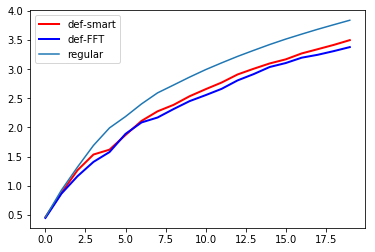

In [88]:
#pi_deflate = calc_pi_vs_dim(cross_cov_mats, V=V_deflate)
pi_deflate_fft = calc_pi_vs_dim(cross_cov_mats, V=V_deflate_fft)
pi_regular = calc_pi_vs_dim(cross_cov_mats, V_all=V_all)
pi_deflate_smart = calc_pi_vs_dim(cross_cov_mats, V=V_deflate_smart)


#plt.plot(pi_deflate, label="deflation", linewidth=5, c="gray")
plt.plot(pi_deflate_smart, label="def-smart", linewidth=2, c="red")
plt.plot(pi_deflate_fft, label="def-FFT", linewidth=2, c="blue")

plt.plot(pi_regular, label="regular")
plt.legend()

In [22]:
X.std(axis=0)

array([0.49038997, 0.58812266, 0.5743383 , 0.48701396, 0.47844398,
       0.51682225, 0.44126605, 0.5632092 , 0.64174168, 0.36374362,
       0.37787176, 0.7508002 , 0.43643   , 0.54887021, 0.63206944,
       0.55570018, 0.61459445, 0.39622379, 0.60667514, 0.59926496,
       0.56654737, 0.41286816, 0.61540279, 0.41220733, 0.53253156,
       0.53112461, 0.36036144, 0.61610593, 0.63212123, 0.40400968,
       0.68771288, 0.38921737, 0.59505555, 0.4903601 , 0.49493503,
       0.51920492, 0.64105834, 0.58048271, 0.67358761, 0.63769045,
       0.67130956, 0.48421135, 0.56531058, 0.53145062, 0.67320525,
       0.48313793, 0.69511328, 0.65606135, 0.52486769, 0.55048453,
       0.37144583, 0.6397047 , 0.60391499, 0.43845572, 0.38706131,
       0.8200575 , 0.57530894, 0.53384453, 0.60161355, 0.5087633 ,
       0.57732981, 0.44688725, 0.39321758, 0.36026892, 0.42187377,
       0.60221882, 0.61816865, 0.47221246, 0.63048399, 0.64792935,
       0.37502226, 0.38032154, 0.64470258, 0.6599456 , 0.40761

In [ ]:
F = np.eye(N)
X = X
basis = np.zeros((N, n_proj))
for i in range(n_proj):
    v = DCA(X).flatten()
    v_full = np.dot(F, v)
    basis[:, i] = v_full
    U = scipy.linalg.orth(np.eye(N) - np.outer(v, v))
    F = np.dot(F, U)
    X = np.dot(X, U)